<a href="https://colab.research.google.com/github/hafnailmy-bip/pertemuanketiga/blob/main/PCD_Pratikum_1_Pertemuan_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== PRAKTIKUM 3: TRANSFORMASI GEOMETRIK DAN INTERPOLASI ===



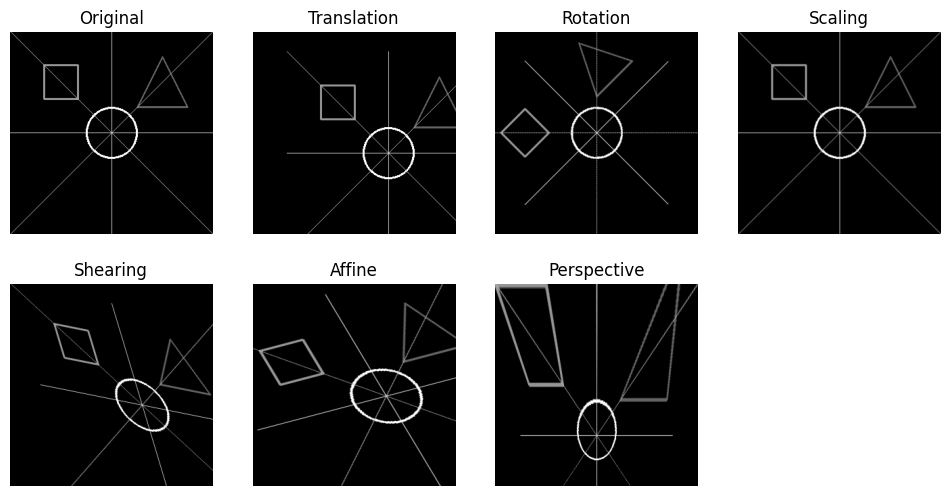

Hasil Transformasi Homogen:
 [[2.         1.         1.        ]
 [3.41421356 2.41421356 1.        ]
 [0.93933983 2.06066017 1.        ]
 [2.35355339 3.47487373 1.        ]]


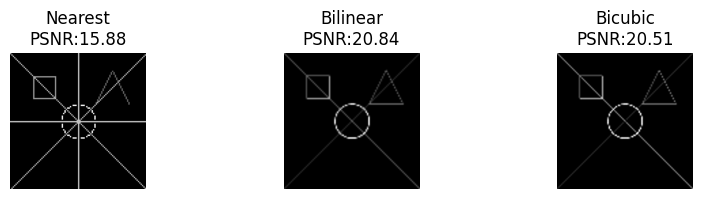

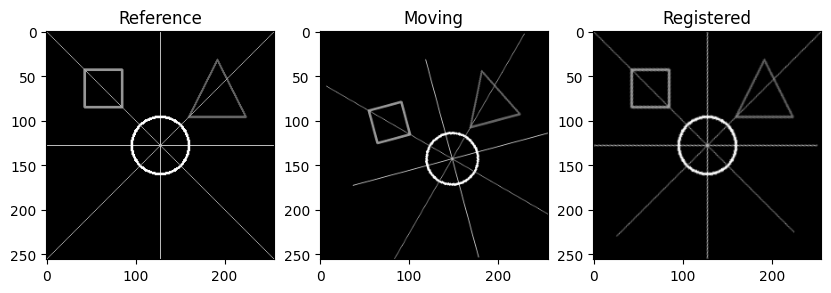

In [3]:
# ============================================
# PRAKTIKUM 3: TRANSFORMASI GEOMETRIK DAN INTERPOLASI
# ============================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import warnings
warnings.filterwarnings('ignore')

print("=== PRAKTIKUM 3: TRANSFORMASI GEOMETRIK DAN INTERPOLASI ===\n")

# =============== FUNGSI BANTU ===============
def create_test_image(size=256):
    img = np.zeros((size, size), dtype=np.uint8)

    cv2.line(img, (size//2, 0), (size//2, size), 200, 1)
    cv2.line(img, (0, size//2), (size, size//2), 200, 1)

    cv2.circle(img, (size//2, size//2), size//8, 255, 2)

    square_size = size//6
    cv2.rectangle(img,
                 (size//4 - square_size//2, size//4 - square_size//2),
                 (size//4 + square_size//2, size//4 + square_size//2),
                 150, 2)

    triangle_pts = np.array([
        [size*3//4, size//4 - size//8],
        [size*3//4 - size//8, size//4 + size//8],
        [size*3//4 + size//8, size//4 + size//8]
    ])
    cv2.polylines(img, [triangle_pts], True, 100, 2)

    cv2.line(img, (0, 0), (size, size), 180, 1)
    cv2.line(img, (size, 0), (0, size), 180, 1)

    return img


def apply_transformation(image, transformation_name, params=None):
    if params is None:
        params = {}

    h, w = image.shape

    if transformation_name == 'translation':
        tx, ty = params.get('tx', 50), params.get('ty', 30)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        result = cv2.warpAffine(image, M, (w, h))

    elif transformation_name == 'rotation':
        angle = params.get('angle', 45)
        center = (w//2, h//2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        result = cv2.warpAffine(image, M, (w, h))

    elif transformation_name == 'scaling':
        sx, sy = params.get('sx', 1.5), params.get('sy', 1.5)
        result = cv2.resize(image, None, fx=sx, fy=sy)

    elif transformation_name == 'shearing':
        M = np.float32([[1, 0.3, 0], [0.2, 1, 0]])
        result = cv2.warpAffine(image, M, (w, h))

    elif transformation_name == 'affine':
        pts1 = np.float32([[50,50], [200,50], [50,200]])
        pts2 = np.float32([[10,100], [200,50], [100,250]])
        M = cv2.getAffineTransform(pts1, pts2)
        result = cv2.warpAffine(image, M, (w, h))

    elif transformation_name == 'perspective':
        pts1 = np.float32([[50,50], [w-50,50], [w-50,h-50], [50,h-50]])
        pts2 = np.float32([[0,0], [w,0], [w-100,h], [100,h]])
        M = cv2.getPerspectiveTransform(pts1, pts2)
        result = cv2.warpPerspective(image, M, (w, h))

    else:
        result = image.copy()

    return result


def compare_interpolation_methods(image):
    h, w = image.shape
    new_size = (w//4, h//4)

    methods = [
        ('Nearest', cv2.INTER_NEAREST),
        ('Bilinear', cv2.INTER_LINEAR),
        ('Bicubic', cv2.INTER_CUBIC)
    ]

    results = []

    for name, method in methods:
        down = cv2.resize(image, new_size, interpolation=method)
        up = cv2.resize(down, (w, h), interpolation=method)

        mse = np.mean((image.astype(float) - up.astype(float))**2)
        psnr = 10 * np.log10(255**2 / mse) if mse > 0 else 0

        results.append((name, down, up, mse, psnr))

    return results


def visualize_homogeneous():
    pts = np.array([[0,0],[1,0],[0,1],[1,1]], dtype=float)
    pts_h = np.hstack([pts, np.ones((4,1))])

    T = np.array([[1,0,2],[0,1,1],[0,0,1]])
    R = np.array([[np.cos(np.pi/4),-np.sin(np.pi/4),0],
                  [np.sin(np.pi/4),np.cos(np.pi/4),0],
                  [0,0,1]])
    S = np.array([[2,0,0],[0,1.5,0],[0,0,1]])

    result = (T @ R @ S @ pts_h.T).T

    print("Hasil Transformasi Homogen:\n", result)


def image_registration():
    ref = create_test_image(256)

    M = cv2.getRotationMatrix2D((128,128), 15, 0.9)
    M[0,2] += 20
    M[1,2] += 15

    moving = cv2.warpAffine(ref, M, (256,256))

    # inverse matrix
    M_full = np.vstack([M, [0,0,1]])
    M_inv = np.linalg.inv(M_full)
    M_inv = M_inv[:2,:]

    registered = cv2.warpAffine(moving, M_inv, (256,256))

    plt.figure(figsize=(10,4))

    plt.subplot(1,3,1)
    plt.imshow(ref, cmap='gray')
    plt.title('Reference')

    plt.subplot(1,3,2)
    plt.imshow(moving, cmap='gray')
    plt.title('Moving')

    plt.subplot(1,3,3)
    plt.imshow(registered, cmap='gray')
    plt.title('Registered')

    plt.show()


# =============== MAIN PROGRAM ===============

# 1. Transformasi dasar
img = create_test_image(300)

titles = ['Original','Translation','Rotation','Scaling','Shearing','Affine','Perspective']
types = ['none','translation','rotation','scaling','shearing','affine','perspective']

plt.figure(figsize=(12,6))

for i, t in enumerate(types):
    plt.subplot(2,4,i+1)
    if t == 'none':
        res = img
    else:
        res = apply_transformation(img, t)
    plt.imshow(res, cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.show()


# 2. Koordinat homogen
visualize_homogeneous()


# 3. Interpolasi
img2 = create_test_image(400)
results = compare_interpolation_methods(img2)

plt.figure(figsize=(10,6))

for i,(name,down,up,mse,psnr) in enumerate(results):
    plt.subplot(3,3,i+1)
    plt.imshow(up, cmap='gray')
    plt.title(f"{name}\nPSNR:{psnr:.2f}")
    plt.axis('off')

plt.show()


# 4. Image Registration
image_registration()